# HR Analytics
Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

1. They first identify a set of employees based on recommendations/ past performance
2. Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
3. At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.

![checkpoint](checkpoint.jpg)

In [1]:
import warnings

warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

from plot_classification_report import plot_classification_report as pcf

In [2]:
# Import train data
df_train = pd.read_csv("train.csv")

df_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
# Import test data
df_test = pd.read_csv("test.csv")

In [4]:
# # Merge train and test set
# df = pd.concat([df_train, df_test]).reset_index(drop = True)
# df.head()

## Data Cleaning

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [6]:
df_train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [7]:
# View value counts of the education column
df_train["education"].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

__Observation__: NA values in the education column will be replaced with the most common degree - "Bachelor's"

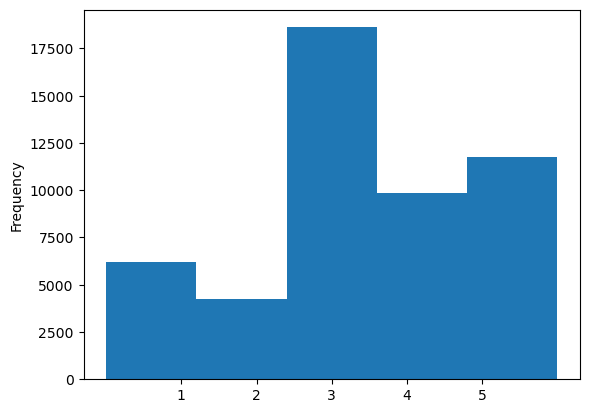

In [8]:
df_train["previous_year_rating"].plot(kind = "hist", bins = 5, range = (0,6))

plt.xticks([1,2,3,4,5]);

__Observation__: Since the data isn't skewed, NA values in the `previous_year_rating` will be replaced with the most common rating: 3

In [9]:
def wrangle_data(df):
    
    # Replace all NA values in the `previous_year_rating` with the most common rating: 3
    df["previous_year_rating"].fillna(3.0, inplace = True)
    
    # replace NA values in education column with most common degree
    df["education"].fillna("Bachelor's", inplace = True)
    
    # Split the strings, extract the second part of the split strings, convert the extracted part to an integer type
    df["region"] = df["region"].str.split('_').str[1].astype(int)    
    
    # Label Encoding: Encoding the degrees in an ordinal fashion
    df["education"] = df["education"].replace({"Master's & above": 2, "Bachelor's": 1,"Below Secondary":0 }).astype(int) 
    
    df = pd.get_dummies(df, columns=['department', "gender", "recruitment_channel"])    
    
    return df

In [10]:
df = wrangle_data(df_train)

In [11]:
# Check for null values
df.isnull().sum()

employee_id                     0
region                          0
education                       0
no_of_trainings                 0
age                             0
previous_year_rating            0
length_of_service               0
KPIs_met >80%                   0
awards_won?                     0
avg_training_score              0
is_promoted                     0
department_Analytics            0
department_Finance              0
department_HR                   0
department_Legal                0
department_Operations           0
department_Procurement          0
department_R&D                  0
department_Sales & Marketing    0
department_Technology           0
gender_f                        0
gender_m                        0
recruitment_channel_other       0
recruitment_channel_referred    0
recruitment_channel_sourcing    0
dtype: int64

__Observation__: No null values

### Dummy Variables

In [13]:
df.head()

,employee_id,region,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,...,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,7,2,1,35,5.0,8,1,0,49,...,0,0,0,1,0,1,0,0,0,1
1,65141,22,1,1,30,5.0,4,0,0,60,...,1,0,0,0,0,0,1,1,0,0
2,7513,19,1,1,34,3.0,7,0,0,50,...,0,0,0,1,0,0,1,0,0,1
3,2542,23,1,2,39,1.0,10,0,0,50,...,0,0,0,1,0,0,1,1,0,0
4,48945,26,1,1,45,3.0,2,0,0,73,...,0,0,0,0,1,0,1,1,0,0


---
## Build Classification Models 
Since this is a classification problem, we'll consider the following classification models for this analysis:

- Logistic Regression
- Support Vector Classifier
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting

### Split Data

In [14]:
X = df.drop(columns = "is_promoted")
y = df["is_promoted"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (43846, 24)
X_test shape: (10962, 24)
y_train shape: (43846,)
y_test shape: (10962,)


### Resample

In [16]:
# Check for class inbalance
df["is_promoted"].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

Since there exists a hige class inbalance, the dataset has to be resampled

In [17]:
over_sampler = RandomOverSampler(random_state= 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)

### Logistic Regression

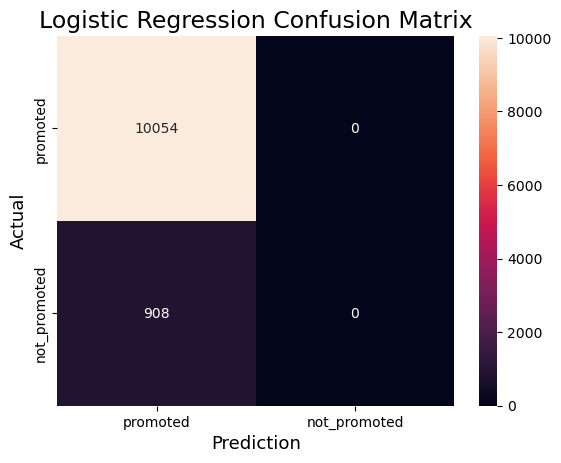

In [18]:
lr =  LogisticRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr.predict(X_test)

# Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr),
    annot = True,
    fmt = 'g',
    xticklabels=['promoted', 'not_promoted'],
    yticklabels= ['promoted', 'not_promoted']
)
plt.ylabel('Actual', fontsize = 13)
plt.xlabel('Prediction', fontsize = 13)
plt.title('Logistic Regression Confusion Matrix', fontsize = 17);

[0.92, 1.0, 0.96]
[0.0, 0.0, 0.0]


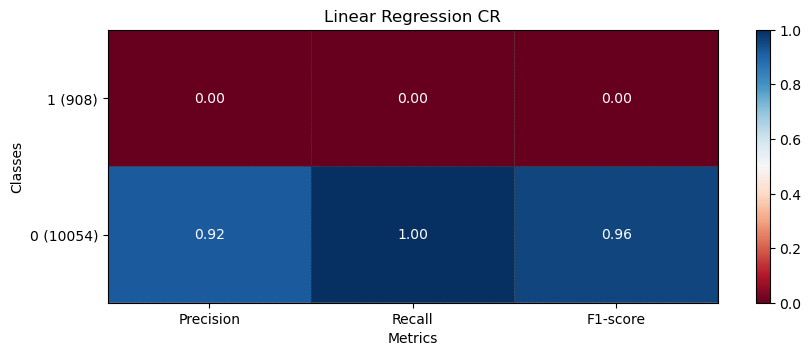

In [19]:
# Classification Report
lr_class_report = classification_report(y_test, y_pred_lr)
pcf(lr_class_report, "Linear Regression CR");

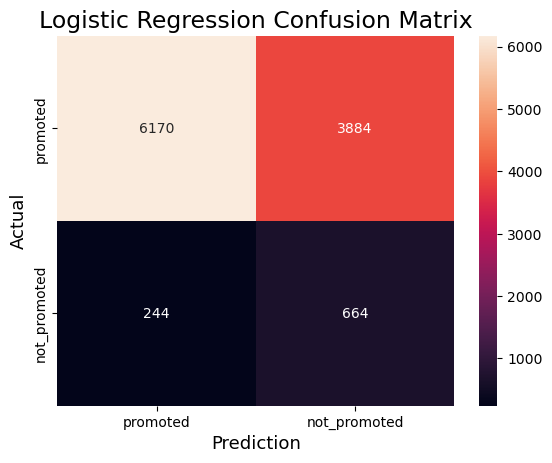

In [25]:
lr_over =  LogisticRegression().fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_lr_over = lr_over.predict(X_test)

# Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr_over),
    annot = True,
    fmt = 'g',
    xticklabels=['promoted', 'not_promoted'],
    yticklabels= ['promoted', 'not_promoted']
)
plt.ylabel('Actual', fontsize = 13)
plt.xlabel('Prediction', fontsize = 13)
plt.title('Logistic Regression Confusion Matrix', fontsize = 17);

[0.96, 0.61, 0.75]
[0.15, 0.73, 0.24]


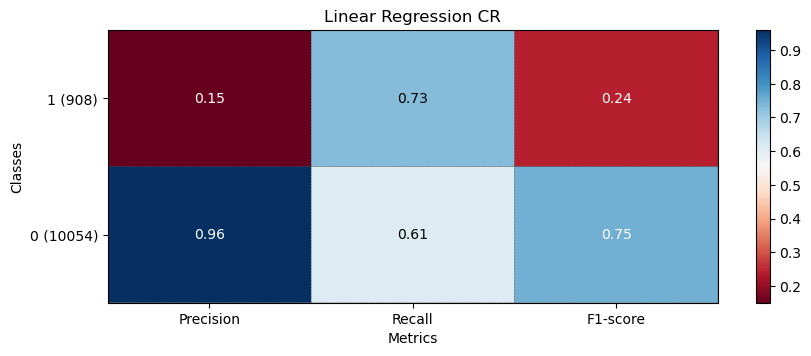

In [21]:
# Classification Report
lr_class_report_over = classification_report(y_test, y_pred_over)
pcf(lr_class_report_over, "Linear Regression CR");

### Support Vector Classifier (SVC)

In [22]:
svc = SVC().fit(X_train, y_train)

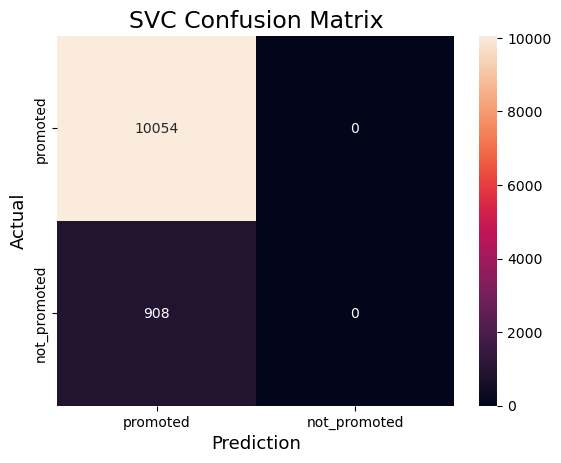

In [28]:
y_pred_svc = svc.predict(X_test)

# Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_svc),
    annot = True,
    fmt = 'g',
    xticklabels=['promoted', 'not_promoted'],
    yticklabels= ['promoted', 'not_promoted']
)
plt.ylabel('Actual', fontsize = 13)
plt.xlabel('Prediction', fontsize = 13)
plt.title('SVC Confusion Matrix', fontsize = 17);

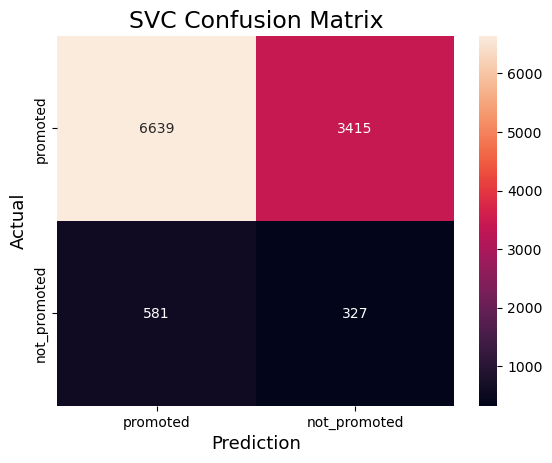

In [30]:
svc_over =  SVC().fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_svc_over = svc_over.predict(X_test)

# Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_svc_over),
    annot = True,
    fmt = 'g',
    xticklabels=['promoted', 'not_promoted'],
    yticklabels= ['promoted', 'not_promoted']
)
plt.ylabel('Actual', fontsize = 13)
plt.xlabel('Prediction', fontsize = 13)
plt.title('SVC Confusion Matrix', fontsize = 17);